In [1]:
import requests
import time
from datetime import datetime
def get_market_by_slug(slug: str) -> dict:
    """Fetch market details directly by slug (no searching)"""
    response = requests.get(
        f"https://gamma-api.polymarket.com/markets",
        params={"slug": slug}
    )
    markets = response.json()
    return markets[0] if markets else None
def get_btc_15m_market(timestamp: int) -> dict:
    """Get BTC 15-min market for a specific timestamp"""
    slug = f"btc-updown-15m-{timestamp}"
    return get_market_by_slug(slug)
def get_next_market_timestamp(current_ts: int) -> int:
    """Calculate next 15-min market timestamp"""
    return current_ts + 900
# Example: Get current market
current_ts = 1766344500
market = get_btc_15m_market(current_ts)
if market:
    print(f"Question: {market['question']}")
    print(f"End Date: {market['endDate']}")
    print(f"Condition ID: {market['conditionId']}")
    print(f"Token IDs: {market['clobTokenIds']}")  # This is what WebSocket needs

    yes_token_id = market['clobTokenIds'][0]
    no_token_id = market['clobTokenIds'][1]

Question: Bitcoin Up or Down - December 21, 2:15PM-2:30PM ET
End Date: 2025-12-21T19:30:00Z
Condition ID: 0x2c7b4c4814dda9c461e773c64eb4e90b91b7ffa9d9a7e81e8aa4b50b95705d3d
Token IDs: ["77659131609082989710007605993140565011705938721134954735628818471535201171215", "106529296555371944933513243107264695413187395835459709951048697294803715414804"]


In [4]:
import json
import threading
import requests
import pandas as pd
from websocket import WebSocketApp
from datetime import datetime
import time

# ============ CONFIGURATION (UPDATE THESE) ============
TOKEN_ID = "77659131609082989710007605993140565011705938721134954735628818471535201171215"                           # From Gamma API
TOKEN_ID_UP = "..."      # Up asset_id
TOKEN_ID_DOWN = "..."    # Down asset_id
MARKET_SLUG = "btc-updown-15m-1766344500"                 # Current market slug
MARKET_END_UNIX = 1766344500 + 900                        # Slug timestamp + 900 seconds
USER_ADDRESS = "0x6031b6eed1c97e853c6e0f03ad3ce3529351f96d"

# ============ SHARED STATE ============
bids = []
asks = []
btc_price = None
books = {
    TOKEN_ID_UP: {"bids": [], "asks": []},
    TOKEN_ID_DOWN: {"bids": [], "asks": []},
}
books_lock = threading.Lock()  # optional but good

# ============ DATA STORAGE ============
orderbook_snapshots = []
user_trades = []
seen_hashes = set()

In [6]:
# ============ WEBSOCKET: Live Orderbook ============
# def on_open(ws):
#     print("[WS] Connected")
#     ws.send(json.dumps({"assets_ids": [TOKEN_ID], "type": "market"}))

def on_open(ws):
    print("[WS] Connected")
    ws.send(json.dumps({"assets_ids": [TOKEN_ID_UP, TOKEN_ID_DOWN], "type": "market"}))

def on_message(ws, message):
    if message == "PONG":
        return
    data = json.loads(message)
    events = data if isinstance(data, list) else [data]

    for event in events:
        if event.get("event_type") != "book":
            continue

        asset_id = event.get("asset_id")
        if asset_id not in books:
            continue

        with books_lock:
            books[asset_id]["bids"] = event.get("bids", []) or []
            books[asset_id]["asks"] = event.get("asks", []) or []

ws = WebSocketApp(
    "wss://ws-subscriptions-clob.polymarket.com/ws/market",
    on_open=on_open,
    on_message=on_message
)
threading.Thread(target=ws.run_forever, daemon=True).start()
print("[WS] Orderbook thread started")

[WS] Orderbook thread started


In [8]:
# ============ BTC PRICE POLLER (CoinGecko) ============
def btc_poller():
    global btc_price
    while True:
        try:
            r = requests.get(
                "https://api.coingecko.com/api/v3/simple/price",
                params={"ids": "bitcoin", "vs_currencies": "usd"},
                timeout=5
            )
            btc_price = float(r.json()["bitcoin"]["usd"])
        except Exception as e:
            print(f"[BTC] Error: {e}")
        time.sleep(1)  # CoinGecko rate limit is stricter

threading.Thread(target=btc_poller, daemon=True).start()
print("[BTC] Price poller started")

[BTC] Price poller started


In [10]:
# ============ ORDERBOOK SAMPLER (10x per second) ============
def top_of_book_levels(levels, n=5):
    """
    levels: list of dicts like {"price": "...", "size": "..."}
    Returns: (best_price, best_size, depth_n)
    Assumes levels are sorted best-at-end (like your current code).
    If ordering is opposite, flip indices (see note below).
    """
    if not levels:
        return (None, None, None)

    best = levels[-1]
    best_price = float(best["price"])
    best_size = float(best["size"])
    depth_n = sum(float(x["size"]) for x in levels[-n:]) if len(levels) >= 1 else 0.0
    return (best_price, best_size, depth_n)
    
def sampler():
    while True:
        now_unix = int(time.time())

        if btc_price:
            with books_lock:
                up_bids = books[TOKEN_ID_UP]["bids"]
                up_asks = books[TOKEN_ID_UP]["asks"]
                down_bids = books[TOKEN_ID_DOWN]["bids"]
                down_asks = books[TOKEN_ID_DOWN]["asks"]

            # Require both sides to exist for both tokens (you can relax this)
            if up_bids and up_asks and down_bids and down_asks:
                up_best_bid, up_bid_size, up_bid_depth_5 = top_of_book_levels(up_bids, n=5)
                up_best_ask, up_ask_size, up_ask_depth_5 = top_of_book_levels(up_asks, n=5)

                down_best_bid, down_bid_size, down_bid_depth_5 = top_of_book_levels(down_bids, n=5)
                down_best_ask, down_ask_size, down_ask_depth_5 = top_of_book_levels(down_asks, n=5)

                orderbook_snapshots.append({
                    "timestamp_unix": now_unix,
                    "market_slug": MARKET_SLUG,

                    # Up token (what you pay to buy Up immediately)
                    "up_best_ask": up_best_ask,
                    "up_ask_size": up_ask_size,
                    "up_ask_depth_5": up_ask_depth_5,

                    # Down token (what you pay to buy Down immediately)
                    "down_best_ask": down_best_ask,
                    "down_ask_size": down_ask_size,
                    "down_ask_depth_5": down_ask_depth_5,

                    # Optional: keep bids too, useful for spread / execution modeling
                    "up_best_bid": up_best_bid,
                    "down_best_bid": down_best_bid,

                    # Optional spreads
                    "up_spread": up_best_ask - up_best_bid,
                    "down_spread": down_best_ask - down_best_bid,

                    "seconds_to_expiry": max(0, MARKET_END_UNIX - now_unix),
                    "btc_price": btc_price,
                })

        time.sleep(0.1)

threading.Thread(target=sampler, daemon=True).start()
print("[SAMPLER] Orderbook sampler started")

[SAMPLER] Orderbook sampler started


In [12]:
# ============ TRADE POLLER ============
def trade_poller():
    while True:
        try:
            r = requests.get(
                "https://data-api.polymarket.com/trades",
                params={"user": USER_ADDRESS, "limit": 100},
                timeout=2
            )
            for trade in r.json():
                tx_hash = trade.get("transactionHash")
                slug = trade.get("slug", "")
                
                if "btc-updown-15m" not in slug:
                    continue
                    
                if tx_hash and tx_hash not in seen_hashes:
                    seen_hashes.add(tx_hash)
                    user_trades.append({
                        "timestamp_unix": trade.get("timestamp"),
                        "market_slug": slug,
                        "side": trade.get("side"),
                        "price": trade.get("price"),
                        "size": trade.get("size"),
                        "outcome": trade.get("outcome"),
                        "tx_hash": tx_hash
                    })
                    print(f"[TRADE] {trade.get('side')} {trade.get('size')} @ {trade.get('price')}")
        except Exception as e:
            print(f"[TRADE] Error: {e}")
        time.sleep(0.1)

threading.Thread(target=trade_poller, daemon=True).start()
print("[TRADE] Trade poller started")

[TRADE] Trade poller started


In [14]:
# Status check
print(f"BTC Price: ${btc_price:,.2f}" if btc_price else "BTC: waiting...")
print(f"Book levels: {len(bids)} bids, {len(asks)} asks")
print(f"Snapshots: {len(orderbook_snapshots)}")
print(f"Trades: {len(user_trades)}")

BTC: waiting...
Book levels: 52 bids, 46 asks
Snapshots: 0
Trades: 87


In [16]:
# Status check
print(f"BTC Price: ${btc_price:,.2f}" if btc_price else "BTC: waiting...")
print(f"Book levels: {len(bids)} bids, {len(asks)} asks")
print(f"Snapshots: {len(orderbook_snapshots)}")
print(f"Trades: {len(user_trades)}")

BTC Price: $88,356.00
Book levels: 47 bids, 51 asks
Snapshots: 114
Trades: 87


In [18]:
print("=== TIMESTAMP RANGES ===")
print(f"Trades: {trades_df['timestamp_unix'].min()} to {trades_df['timestamp_unix'].max()}")
print(f"Orderbook: {ob_df['timestamp_unix'].min()} to {ob_df['timestamp_unix'].max()}")

=== TIMESTAMP RANGES ===
[BTC] Error: 'bitcoin'


NameError: name 'trades_df' is not defined

In [23]:
import pandas as pd

ob_df = pd.DataFrame(orderbook_snapshots)
trades_df = pd.DataFrame(user_trades)

print("=== TIMESTAMP RANGES ===")
print(f"Trades: {trades_df['timestamp_unix'].min()} to {trades_df['timestamp_unix'].max()}")
print(f"Orderbook: {ob_df['timestamp_unix'].min()} to {ob_df['timestamp_unix'].max()}")

=== TIMESTAMP RANGES ===
Trades: 1766343938 to 1766344594
Orderbook: 1766344623 to 1766344692


In [25]:
print(f"Trades: {trades_df['timestamp_unix'].min()} to {trades_df['timestamp_unix'].max()}")
print(f"Orderbook: {ob_df['timestamp_unix'].min()} to {ob_df['timestamp_unix'].max()}")
print(f"Overlap exists: {trades_df['timestamp_unix'].max() >= ob_df['timestamp_unix'].min()}")

[BTC] Error: 'bitcoin'
Trades: 1766343938 to 1766344594
Orderbook: 1766344623 to 1766344692
Overlap exists: False


In [27]:
# Run this every minute or so
ob_start = pd.DataFrame(orderbook_snapshots)["timestamp_unix"].min()
new_trades = [t for t in user_trades if t["timestamp_unix"] >= ob_start]
print(f"Trades with matching orderbook data: {len(new_trades)}")

Trades with matching orderbook data: 6


In [31]:
import pandas as pd

ob_df = pd.DataFrame(orderbook_snapshots)
trades_df = pd.DataFrame(user_trades)

merged = pd.merge_asof(
    trades_df.sort_values("timestamp_unix"),
    ob_df.sort_values("timestamp_unix"),
    on="timestamp_unix",
    direction="backward",
    suffixes=("_trade", "_book")
)

print(f"Merged rows: {len(merged)}")
display(merged.tail(20))

[BTC] Error: 'bitcoin'
Merged rows: 98


,timestamp_unix,market_slug_trade,side,price,size,outcome,tx_hash,market_slug_book,best_bid,best_ask,spread,bid_size,ask_size,bid_depth_5,ask_depth_5,seconds_to_expiry,btc_price
78,1766344550,btc-updown-15m-1766344500,BUY,0.50,20.00,Up,0x235e6583594a5897eb7e14ae46ed2fd3266788290203...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,1766344550,btc-updown-15m-1766344500,BUY,0.50,20.00,Up,0x9a88afe3d65edc07b4d536170d22fa698ac27bda86f2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80,1766344552,btc-updown-15m-1766344500,BUY,0.50,5.00,Up,0x50af9b963caeb35ea28cac636bbb21451515d3f0074a...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,1766344552,btc-updown-15m-1766344500,BUY,0.50,5.00,Up,0xa359aa11e3e7365f039faa9ad85cc5b28d7ccecf41e3...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,1766344552,btc-updown-15m-1766344500,BUY,0.50,20.00,Up,0xcb1fec54c2b7a62b56663fcc06423c7c0e045f9c94f6...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,1766344552,btc-updown-15m-1766344500,BUY,0.50,20.00,Up,0x8908398767a395d1abda0d8d00e58d59e87742ea5d69...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,1766344552,btc-updown-15m-1766344500,BUY,0.50,20.00,Up,0xf1473b35e7b02f53be89c141242ef3fb850a64d662ed...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,1766344554,btc-updown-15m-1766344500,BUY,0.48,20.00,Down,0x1ee1922b7aea87b9f717cdec2d56a8d0c5fabc985a72...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,1766344594,btc-updown-15m-1766344500,BUY,0.50,15.50,Down,0x2d5282048e268cb94006a07783624c25ca5b1a3e5031...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,1766344604,btc-updown-15m-1766344500,BUY,0.45,1.05,Up,0xdc39ce06f16b21874fb4b35789733015e9bfe6181b65...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
import pandas as pd

ob_df = pd.DataFrame(orderbook_snapshots)
trades_df = pd.DataFrame(user_trades)

merged = pd.merge_asof(
    trades_df.sort_values("timestamp_unix"),
    ob_df.sort_values("timestamp_unix"),
    on="timestamp_unix",
    direction="backward",
    suffixes=("_trade", "_book")
)

print(f"Merged rows: {len(merged)}")
display(merged.tail(20))

[BTC] Error: 'bitcoin'


ValueError: Length of values (2961) does not match length of index (2962)

In [35]:
merged.groupby(["side", "outcome"]).size()

[BTC] Error: 'bitcoin'


side  outcome
BUY   Down       58
      Up         40
dtype: int64

In [37]:
merged.groupby("outcome")["price"].mean()

outcome
Down    0.790297
Up      0.299901
Name: price, dtype: float64

<Axes: >

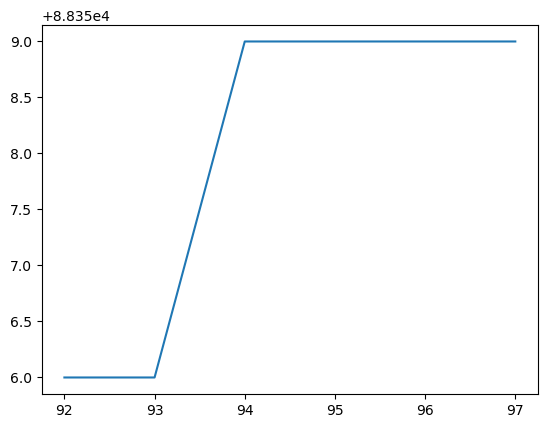

In [39]:
# Do they buy YES when BTC is rising?
merged["btc_price"].plot()

In [41]:
merged["spread"].describe()

count    6.000000
mean     0.011667
std      0.004082
min      0.010000
25%      0.010000
50%      0.010000
75%      0.010000
max      0.020000
Name: spread, dtype: float64

<Axes: >

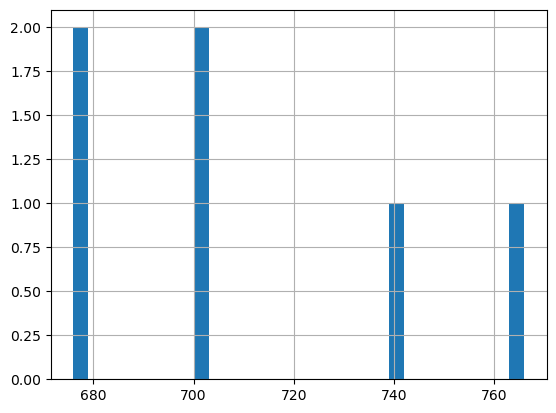

In [43]:
# Visualize
merged["seconds_to_expiry"].hist(bins=30)

In [45]:
# Distribution of seconds_to_expiry when they trade
merged["seconds_to_expiry"].describe()

count      6.000000
mean     710.666667
std       35.612732
min      676.000000
25%      684.000000
50%      702.000000
75%      730.500000
max      766.000000
Name: seconds_to_expiry, dtype: float64

In [47]:
# Did they pay the ask (aggressive) or get filled at bid (passive)?
merged["crossed_spread"] = (
    ((merged["side"] == "BUY") & (merged["price"] >= merged["best_ask"])) |
    ((merged["side"] == "SELL") & (merged["price"] <= merged["best_bid"]))
)

print("Crossed spread (aggressive):")
print(merged["crossed_spread"].value_counts())

[BTC] Error: 'bitcoin'
Crossed spread (aggressive):
crossed_spread
False    94
True      4
Name: count, dtype: int64


In [49]:
merged.groupby("outcome")["size"].agg(["count", "sum"])

,count,sum
outcome,,
Down,58,931.38
Up,40,660.53


In [51]:
# Average price they pay vs the ask
merged["vs_ask"] = merged["price"] - merged["best_ask"]
print(merged[["outcome", "price", "best_ask", "vs_ask"]])

   outcome  price  best_ask  vs_ask
0     Down   0.53       NaN     NaN
1       Up   0.41       NaN     NaN
2     Down   0.61       NaN     NaN
3       Up   0.38       NaN     NaN
4       Up   0.38       NaN     NaN
..     ...    ...       ...     ...
93      Up   0.49      0.50   -0.01
94      Up   0.55      0.55    0.00
95      Up   0.55      0.55    0.00
96    Down   0.47      0.48   -0.01
97    Down   0.48      0.48    0.00

[98 rows x 4 columns]


In [59]:
print(merged[["timestamp_unix", "outcome", "price", "size"]].to_string())

[BTC] Error: 'bitcoin'
    timestamp_unix outcome     price   size
0       1766343938    Down  0.530000  20.00
1       1766343948      Up  0.410000  20.00
2       1766343968    Down  0.610000  20.00
3       1766344006      Up  0.380000  20.00
4       1766344006      Up  0.380000  20.00
5       1766344008    Down  0.630000  20.00
6       1766344018    Down  0.620000   8.38
7       1766344028    Down  0.700000  20.00
8       1766344028    Down  0.700000  20.00
9       1766344034    Down  0.770000  20.00
10      1766344042    Down  0.800000   5.00
11      1766344056      Up  0.180000  19.00
12      1766344056      Up  0.180000  19.00
13      1766344056      Up  0.180000  19.00
14      1766344056      Up  0.180000  19.00
15      1766344056      Up  0.180000  19.00
16      1766344056      Up  0.180000  19.00
17      1766344062    Down  0.840000  19.00
18      1766344062    Down  0.840000  19.00
19      1766344062    Down  0.860000  19.00
20      1766344062    Down  0.840000  19.00
21      1

In [69]:
import pandas as pd

ob_df = pd.DataFrame(orderbook_snapshots)
trades_df = pd.DataFrame(user_trades)

merged = pd.merge_asof(
    trades_df.sort_values("timestamp_unix"),
    ob_df.sort_values("timestamp_unix"),
    on="timestamp_unix",
    direction="backward",
    suffixes=("_trade", "_book")
)

print(f"Merged rows: {len(merged)}")
display(merged.tail(80))

[BTC] Error: 'bitcoin'
Merged rows: 168


,timestamp_unix,market_slug_trade,side,price,size,outcome,tx_hash,market_slug_book,best_bid,best_ask,spread,bid_size,ask_size,bid_depth_5,ask_depth_5,seconds_to_expiry,btc_price
88,1766344604,btc-updown-15m-1766344500,BUY,0.45,1.05,Up,0xdc39ce06f16b21874fb4b35789733015e9bfe6181b65...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,1766344608,btc-updown-15m-1766344500,BUY,0.47,5.00,Down,0x16ef38ac704e33e81067e3b09c6ad2daca21b5fa9836...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
90,1766344608,btc-updown-15m-1766344500,BUY,0.47,15.50,Down,0xf658fdf8bcd8f112103777d685b94a6a1bbe986a1e37...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
91,1766344610,btc-updown-15m-1766344500,BUY,0.47,5.00,Down,0x565406711917cb9c0faea4ff813fe07a19b8ca1e6bab...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,1766344634,btc-updown-15m-1766344500,BUY,0.53,10.00,Up,0xc749ae84469e94e84d9ee78944af907f38158374e473...,btc-updown-15m-1766344500,0.47,0.48,0.01,25.00,543.91,1038.89,2596.37,766.0,88356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1766345462,btc-updown-15m-1766345400,BUY,0.61,20.00,Down,0x27633a24865f34a69a158ad69fd58e27bcc50bdfc00a...,btc-updown-15m-1766344500,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
164,1766345464,btc-updown-15m-1766345400,BUY,0.61,20.00,Down,0xc2a686c04ab58577c25fff91d402f62bf7bcada38cf0...,btc-updown-15m-1766344500,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
165,1766345490,btc-updown-15m-1766345400,BUY,0.74,20.00,Down,0x1def58c457422434dec759e684cacd3f7ed1240a99d5...,btc-updown-15m-1766344500,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
166,1766345490,btc-updown-15m-1766345400,BUY,0.74,20.00,Down,0xd78399e9a84eebf86748327172b8e4cf82263b61dc11...,btc-updown-15m-1766344500,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0


In [75]:
filtered = merged[["timestamp_unix", "side", "price", "size", "outcome", "best_bid", "best_ask", "spread", "bid_size", "ask_size", "bid_depth_5", "ask_depth_5", "seconds_to_expiry", "btc_price"]]

In [79]:
filtered.head(200)

[BTC] Error: 'bitcoin'


,timestamp_unix,side,price,size,outcome,best_bid,best_ask,spread,bid_size,ask_size,bid_depth_5,ask_depth_5,seconds_to_expiry,btc_price
0,1766343938,BUY,0.53,20.0,Down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1766343948,BUY,0.41,20.0,Up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1766343968,BUY,0.61,20.0,Down,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1766344006,BUY,0.38,20.0,Up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1766344006,BUY,0.38,20.0,Up,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1766345462,BUY,0.61,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
164,1766345464,BUY,0.61,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
165,1766345490,BUY,0.74,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
166,1766345490,BUY,0.74,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0


In [81]:
filtered = filtered.dropna(subset=["best_bid"])

In [85]:
filtered.head(100)

,timestamp_unix,side,price,size,outcome,best_bid,best_ask,spread,bid_size,ask_size,bid_depth_5,ask_depth_5,seconds_to_expiry,btc_price
92,1766344634,BUY,0.53,10.0,Up,0.47,0.48,0.01,25.00,543.91,1038.89,2596.37,766.0,88356.0
93,1766344660,BUY,0.49,10.0,Up,0.48,0.50,0.02,253.97,70.05,2175.16,2801.01,740.0,88356.0
94,1766344698,BUY,0.55,20.0,Up,0.54,0.55,0.01,78.44,92.13,3167.40,1525.37,702.0,88359.0
95,1766344698,BUY,0.55,20.0,Up,0.54,0.55,0.01,78.44,92.13,3167.40,1525.37,702.0,88359.0
96,1766344722,BUY,0.47,5.0,Down,0.48,0.49,0.01,3.06,146.92,1405.33,2314.83,678.0,88359.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1766345462,BUY,0.61,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
164,1766345464,BUY,0.61,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
165,1766345490,BUY,0.74,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
166,1766345490,BUY,0.74,20.0,Down,0.01,0.02,0.01,1151.63,922.51,1151.63,1468.39,5.0,88337.0
